In [83]:
from dataset import BKG, SIG, AtlasDataset
from loss_functions import mse_loss, mae_loss
from preprocess import train_val_test_split, normalize

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [85]:
from typing import List

class AutoEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, arch: List[int]):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.arch = arch

        if len(arch) == 0:
            raise ValueError("Encoder architecture must have at least one layer")

        if latent_dim >= arch[-1]:
            raise ValueError("Latent dimension must be smaller than the last encoder layer")

        self.encoder = self._encoder()
        self.decoder = self._decoder()

    def _encoder(self) -> nn.Sequential:
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.arch[0]),
            nn.ReLU()
        )

        for i in range(1, len(self.arch)):
            self.encoder.add_module(f"fc({i})", nn.Linear(self.arch[i - 1], self.arch[i]))
            self.encoder.add_module(f"A({i})", nn.ReLU())

        self.encoder.add_module(f"A({i+1})", nn.ReLU())
        self.encoder.add_module("encoder_output", nn.Linear(self.arch[-1], self.latent_dim))

        return self.encoder

    def _decoder(self) -> nn.Sequential:
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.arch[-1]),
            nn.ReLU()
        )

        for i in range(len(self.arch) - 1, 0, -1):
            self.decoder.add_module(f"fc({i})", nn.Linear(self.arch[i], self.arch[i - 1]))
            self.decoder.add_module(f"A({i})", nn.ReLU())

        self.decoder.add_module("decoder_output", nn.Linear(self.arch[0], self.input_dim))

        return self.decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [86]:
bkg = pd.read_hdf("data/bkg_pythia_sanitised_features.h5")
sig = pd.read_hdf("data/hg3000_hq1000_pythia_sanitised_features.h5")

In [87]:
train, val, test = train_val_test_split(bkg, sig, sample_size=100_000)

scaler = StandardScaler()
x_train, y_train, w_train = normalize(train, scaler, is_train=True)
x_val, y_val, w_val = normalize(val, scaler)
x_test, y_test, w_test = normalize(test, scaler)

In [88]:
print("Sample sizes:")
print(f"\tTrain      - {len(train)}")
print(f"\tTest       - {len(test)}")
print(f"\tValidation - {len(val)}")

print("\nMean, Std and Weights sum (after normalization):")
print(f"\tTrain:")
print(f"\t\tX - {x_train.mean()} +- {x_train.std()}")
print(f"\t\tY - {y_train.mean()} +- {y_train.std()}")
print(f"\t\tW - Bkg: {w_train[y_train == BKG].sum()}, Sig: {w_train[y_train == SIG].sum()}")
print(f"\tTest:")
print(f"\t\tX - {x_test.mean()} +- {x_test.std()}")
print(f"\t\tY - {y_test.mean()} +- {y_test.std()}")
print(f"\t\tW - Bkg: {w_test[y_test == BKG].sum()}, Sig: {w_test[y_test == SIG].sum()}")
print(f"\tValidation:")
print(f"\t\tX - {x_val.mean()} +- {x_val.std()}")
print(f"\t\tY - {y_val.mean()} +- {y_val.std()}")
print(f"\t\tW - Bkg: {w_val[y_val == BKG].sum()}, Sig: {w_val[y_val == SIG].sum()}")

Sample sizes:
	Train      - 33333
	Test       - 33334
	Validation - 33333

Mean, Std and Weights sum (after normalization):
	Train:
		X - 3.501347728414288e-18 +- 1.0
		Y - 0.028020280202802027 +- 0.16503073683456213
		W - Bkg: 16666.5, Sig: 16666.500000000007
	Test:
		X - 0.00023022958900837623 +- 1.0016334727556733
		Y - 0.028049439011219774 +- 0.165114105946087
		W - Bkg: 16667.0, Sig: 16667.000000000015
	Validation:
		X - -0.0006511795583363361 +- 1.001955738253956
		Y - 0.028020280202802027 +- 0.16503073683456213
		W - Bkg: 16666.5, Sig: 16666.500000000007


In [89]:
train_dataset = AtlasDataset(x_train[y_train == BKG], y_train[y_train == BKG], w_train[y_train == BKG])
val_dataset = AtlasDataset(x_val[y_val == BKG], y_val[y_val == BKG], w_val[y_val == BKG])
test_dataset = AtlasDataset(x_test, y_test, w_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=16)

In [97]:
model = AutoEncoder(x_train.shape[1], 6, [32, 16, 8]).to(device=device)
loss_fn = mae_loss

## Train and Validation

## Test

In [98]:
x_recs = []
losses = []

model.eval()
with torch.no_grad():
    for i, (x, y, w) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        w = w.to(device)

        x_rec = model(x)
        loss = loss_fn(x_rec, x, w)

        x_recs.append(x_rec)
        losses.append(loss)

x_recs = torch.cat(x_recs).cpu().detach().numpy()
losses = torch.cat(losses).sum(dim=1).cpu().detach().numpy()

print(x_recs.shape, losses.shape)

(33334, 47) (33334,)


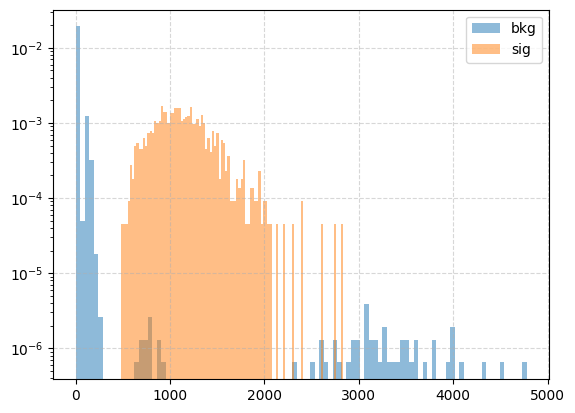

In [99]:
plt.clf()
plt.hist(losses[y_test == BKG], bins=100, density=True, alpha=0.5, label='bkg')
plt.hist(losses[y_test == SIG], bins=100, density=True, alpha=0.5, label='sig')
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()